# Guide Calling Using the Cellranger Module HDF5 File 
## Utilising Direct Capture Perturb-Seq to Deciphering Alternative Promoter Usage  

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  **CNV Score & Numbat to quantify and Velocity quantification with loom file**
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment

In [ ]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="../../../alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import scvelo as scv
from matplotlib_venn import venn3

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import os 
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'


# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])



print("Scanpy", sc.__version__)
%matplotlib inline

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scanpy 1.10.3


In [3]:
adata = ad.read_h5ad(loc+"files/adata_normalised_cellcycle.h5ad")
adata.X = adata.layers["counts"]

In [4]:
#calculate leiden
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.leiden(adata, resolution=0.5, key_added="leiden")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
def run_single_guide_regression(adataControl, controlGuides, guideIndex, expressionMatrix, method='NB'):
    """
    Test whether a single control guide induces transcriptional changes across genes.
    
    Parameters:
    - adataControl: AnnData object filtered to only include control guide cells.
    - controlGuides: List of control guide names.
    - guideIndex: Index of the control guide to test.
    - expressionMatrix: DataFrame of gene expression (cells x genes).
    - method: 'NB' or 'OLS'
    
    Returns:
    - DataFrame with results per gene (Gene, Coef, StdErr, Pval)
    """
    guide_name = controlGuides[guideIndex]
    print(f"Running regression for guide: {guide_name}")
    
    # Create binary predictor: 1 = cell has this guide, 0 = other control guides
    covariate_df = adataControl.obs[["guide_identity", "n_genes_by_counts", "pct_counts_mt", "leiden"]].copy()
    covariate_df["is_guide"] = (covariate_df["guide_identity"] == guide_name).astype(int)
    
    results = []
    for gene in expressionMatrix.columns:
        covariate_df["y"] = expressionMatrix[gene].values
        
        formula = "y ~ is_guide + n_genes_by_counts + pct_counts_mt + C(leiden)"  # Use C() for categorical leiden
        try:
            if method == 'NB':
                model = smf.glm(formula=formula, data=covariate_df,
                                family=sm.families.NegativeBinomial()).fit()
            elif method == 'OLS':
                model = smf.ols(formula=formula, data=covariate_df).fit()
            else:
                raise ValueError("Method must be 'NB' or 'OLS'")
            
            coef = model.params.get("is_guide", np.nan)
            pval = model.pvalues.get("is_guide", np.nan)
            stderr = model.bse.get("is_guide", np.nan)
            results.append((gene, coef, stderr, pval))
        except Exception as e:
            results.append((gene, np.nan, np.nan, np.nan))

    res_df = pd.DataFrame(results, columns=["Gene", "Coef", "StdErr", "Pval"])
    res_df["Guide"] = guide_name
    return res_df



    """
    Create a volcano plot for regression results.
    """
    res_df = res_df.copy()
    res_df["-log10Pval"] = -np.log10(res_df["Pval"])
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=res_df, x="Coef", y="-log10Pval", alpha=0.6, edgecolor=None)

    # Highlight significant hits
    sig_hits = res_df[(res_df["Pval"] < pval_threshold) & (res_df["Coef"].abs() > lfc_threshold)]
    plt.scatter(sig_hits["Coef"], sig_hits["-log10Pval"], color="red", alpha=0.8)

    plt.axhline(-np.log10(pval_threshold), color='gray', linestyle='--', label=f'p={pval_threshold}')
    plt.axvline(-lfc_threshold, color='gray', linestyle='--')
    plt.axvline(lfc_threshold, color='gray', linestyle='--')

    plt.title(f"Volcano Plot for Guide: {guide_name}")
    plt.xlabel("Coefficient (effect size)")
    plt.ylabel("-log10(p-value)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [77]:
# STEP 1: Define control guide cells (e.g. NTC or CTRL in identity)
#get all guides names into a list for adata.obs['guide_target'][].unique(
controlGuides = adata.obs['guide_identity'][adata.obs['guide_identity'].str.startswith('non-tar')].unique().tolist()
control_mask = adata.obs['guide_identity'].isin(controlGuides[5:25])  # Adjust this to select your control guides
adataControl = adata[control_mask].copy()
#filter for first twenty guides 
# STEP 2: Prepare expression matrix

expressionMatrix = pd.DataFrame(adataControl.layers["log1p"])
expressionMatrix.columns = adata.var_names
expressionMatrix.index = adataControl.obs_names

In [ ]:
pca = PCA(n_components=100)
pcs = pca.fit_transform(expressionMatrix)  # shape = (n_cells, 100)


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
design_matrix = encoder.fit_transform(adataControl.obs[['guide_assignment']])
guide_names = encoder.categories_[0]  # guide column names


In [ ]:

betas = []
for i in range(pcs.shape[1]):  # for each PC
    model = sm.OLS(pcs[:, i], sm.add_constant(design_matrix)).fit()
    betas.append(model.params[1:])  # skip intercept

coeff_matrix = np.vstack(betas).T  # shape = (n_guides x n_PCs)

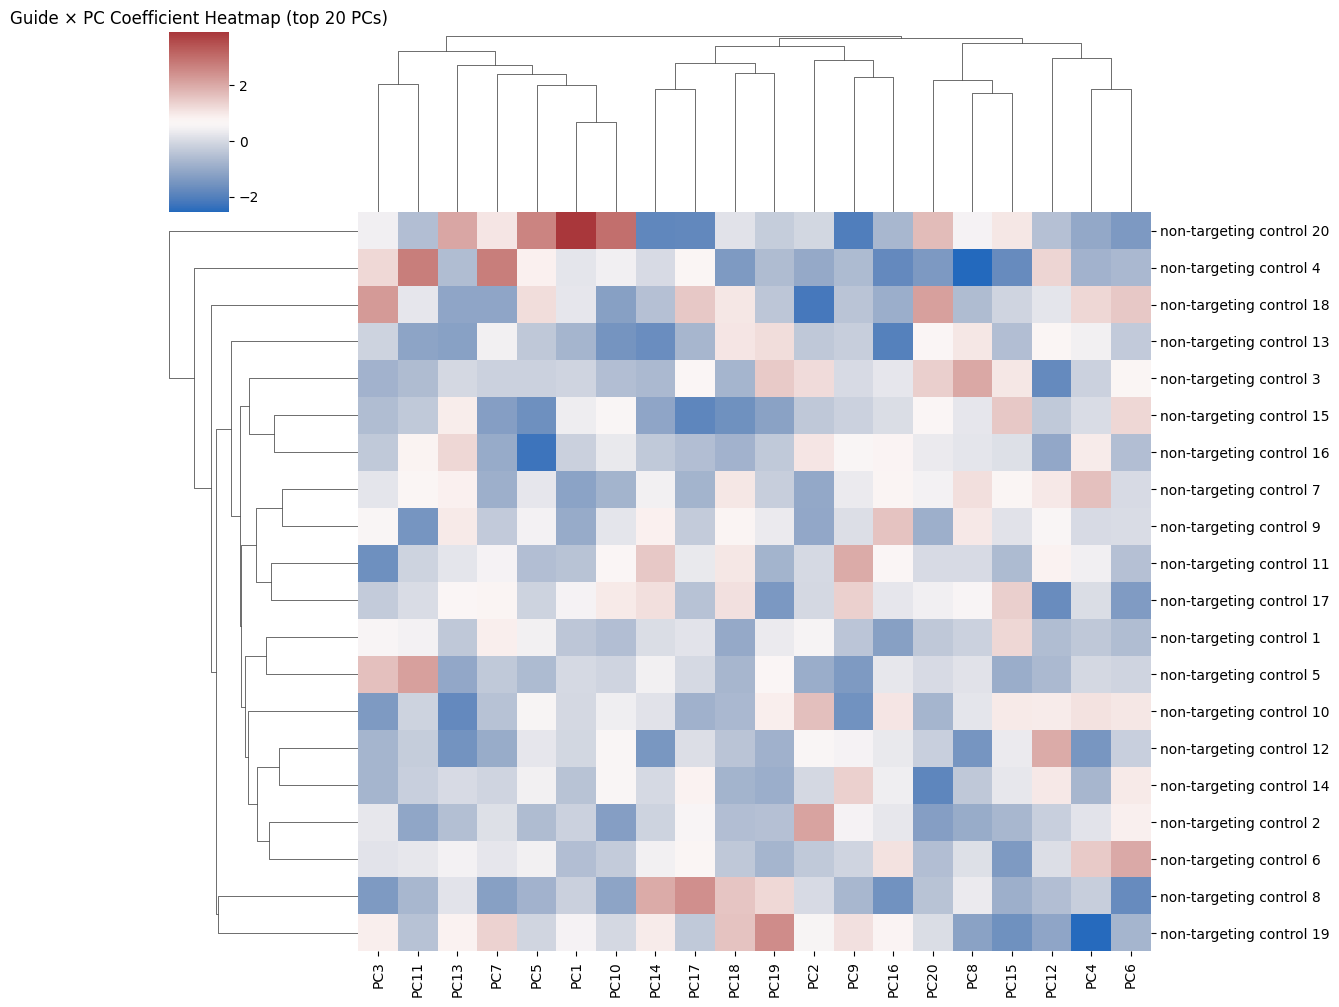

In [ ]:

scaled = StandardScaler().fit_transform(coeff_matrix)

# Select top 20 PCs (columns)
sns.clustermap(pd.DataFrame(scaled[:, :20], index=guide_names),
               cmap="vlag", metric="euclidean", figsize=(12, 10),
               xticklabels=[f"PC{i+1}" for i in range(20)],
                yticklabels=[f"non-targeting control {i+1}" for i in range(20)])

plt.title("Guide × PC Coefficient Heatmap (top 20 PCs)")
plt.show()


In [ ]:


models = {
    "IsolationForest": IsolationForest(random_state=0, contamination=0.1),
    "EllipticEnvelope": EllipticEnvelope(contamination=0.1),
    "LocalOutlierFactor": LocalOutlierFactor(),
    "OneClassSVM": OneClassSVM( nu=0.01)
}
c=0
outlier_scores = {}
#subset coeff_matrix array to be only first 20 
for name, model in models.items():
    print(f"Running model: {name}")
    
    if name == "LocalOutlierFactor":
        pred = model.fit_predict(coeff_matrix)
    else:
        model.fit(coeff_matrix)
        pred = model.predict(coeff_matrix)
    #add the votes with the name to the guide
    #if reaching 20 then break
    outlier_scores[name] = pd.Series(pred, index=guide_names, name=name)


Running model: IsolationForest
Running model: EllipticEnvelope
Running model: LocalOutlierFactor
Running model: OneClassSVM


In [83]:
outlier_counts_side = pd.DataFrame(outlier_scores).apply(lambda x: (x == -1).sum(), axis=0)

In [84]:
outlier_counts_side

IsolationForest        0
EllipticEnvelope       2
LocalOutlierFactor     0
OneClassSVM           20
dtype: int64

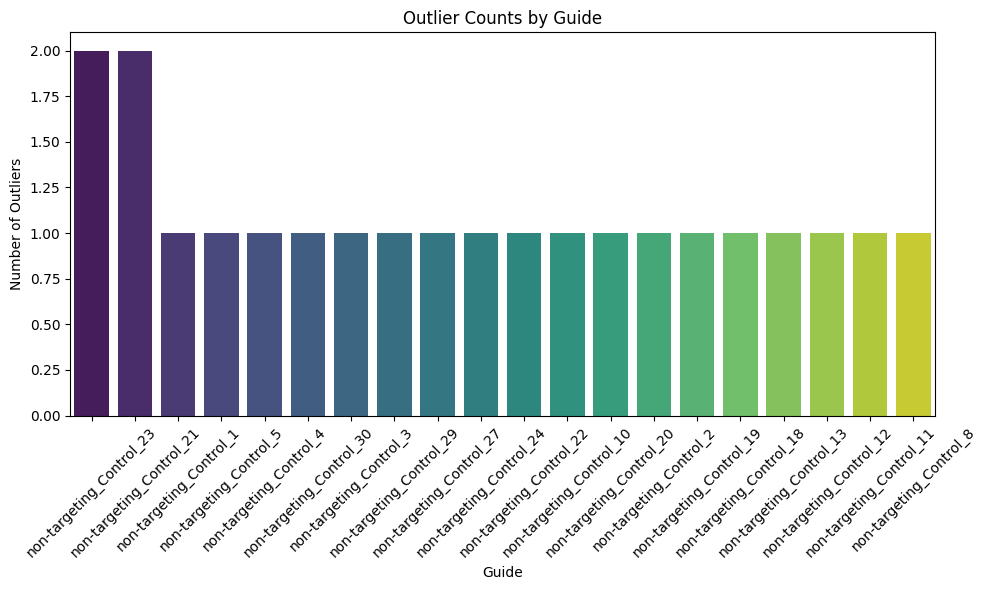

In [75]:
# sum the number of -1 per row in pd.DataFrame(outlier_scores) and make into barplit
#subset to only first 20 guides
outlier_counts = pd.DataFrame(outlier_scores).apply(lambda x: (x == -1).sum(), axis=1)
outlier_counts = outlier_counts.head(20)

outlier_counts = outlier_counts.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Guide")
plt.ylabel("Number of Outliers")
plt.title("Outlier Counts by Guide")
plt.tight_layout()
plt.show()


In [76]:
#create a count plot of the number of outlier 
plt.figure(figsize=(10, 6))
county=pd.DataFrame(outlier_counts.value_counts()).reset_index()
county.head()

,index,count
0,1,18
1,2,2


<Figure size 1000x600 with 0 Axes>

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


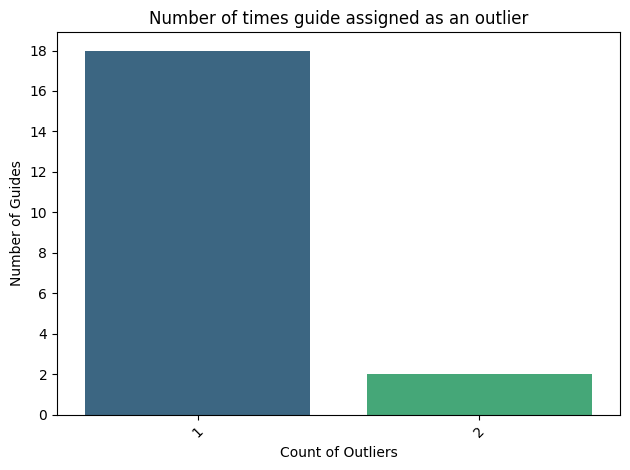

In [88]:

sns.barplot(county, x="index",y="count", palette="viridis")
#add line at y=3
plt.xticks(rotation=45)
plt.xlabel("Count of Outliers")
plt.ylabel("Number of Guides")
plt.title("Number of times guide assigned as an outlier")
#make y axis to lavel every two
plt.yticks(np.arange(0, county['count'].max()+1, 2))
#save as pdf
plt.tight_layout()
plt.savefig(loc+"figures/number_of_outliers_per_guide.pdf")

,IsolationForest,EllipticEnvelope,LocalOutlierFactor,OneClassSVM
non-targeting_00084,-1,1,-1,-1
non-targeting_00202,-1,1,-1,-1
non-targeting_00303,-1,1,-1,-1
non-targeting_00362,-1,1,1,-1
non-targeting_00373,-1,1,1,-1
non-targeting_00715,-1,-1,-1,-1
non-targeting_00759,-1,1,-1,-1
non-targeting_00790,-1,1,-1,-1
non-targeting_00850,-1,1,-1,-1
non-targeting_00867,-1,1,-1,-1
